In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pickle
import os
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colorbar as cbar
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection

import sklearn
from sklearn.model_selection import train_test_split

from utils.data_utils import *
from utils.model_utils import *
from utils.insert_shapelet import multiple_insert_shapelet
from utils.implet_extactor import implet_extractor

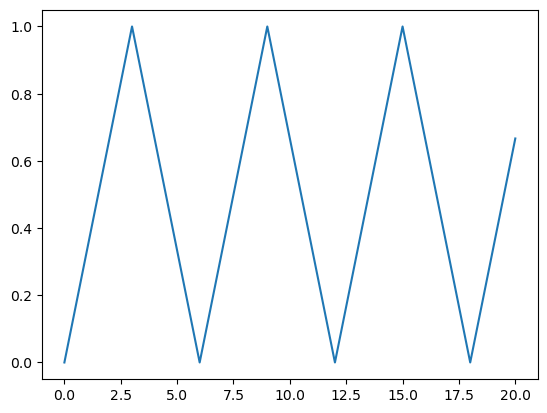

In [2]:
def create_1d_zigzag_array(seq_len, cycle_len):
    """
    Generate a zigzag pattern for a sequence.
    
    Parameters:
        seq_len (int): Total sequence length.
        cycle_len (int): Length of one zigzag cycle (up and down).
    
    Returns:
        np.ndarray: An array containing the zigzag pattern.
    """
    # Ensure cycle_len is at least 2 to create a zigzag pattern
    if cycle_len < 2:
        raise ValueError("cycle_len must be at least 2.")
    
    # Generate one cycle of the zigzag (up and down)
    half_cycle = cycle_len // 2
    upward = np.arange(half_cycle) / half_cycle  # e.g., [0, 1, 2, ...]
    downward = np.arange(half_cycle, 0, -1)  / half_cycle  # e.g., [2, 1]
    full_cycle = np.concatenate((upward, downward[:cycle_len - len(upward)]))
    
    # Tile the cycles to cover the full sequence length
    num_repeats = (seq_len + len(full_cycle) - 1) // len(full_cycle)
    zigzag = np.tile(full_cycle, num_repeats)[:seq_len]
    
    return zigzag

# Example: create a zigzag array of size 10
zigzag_array = create_1d_zigzag_array(21, 7)
plt.plot(zigzag_array)

In [3]:
s1 = np.concatenate((np.arange(0,1.1,0.1),np.arange(0.9,-0.1,-0.1)))  #np.concatenate((np.arange(-0.5,0.5,0.1),np.arange(0.5,-0.6,-0.1))) + 0.5
s2 = -(np.concatenate((np.arange(0,1.1,0.1),np.arange(0.9,-0.1,-0.1))))  #np.concatenate((np.arange(0.5,-0.5,-0.1),np.arange(-0.5,0.6,0.1))) - 0.5
s3 = np.array([0.5]*21)    #np.sin(np.linspace(0,np.pi,21)) #np.array([1]*21)
s4 = np.array([-0.5]*21)  ##np.arange(0,-1.05,-0.05) #-np.sin(np.linspace(0,np.pi,21)) # np.array([-1]*21)
s5 = np.arange(-0.5,0.6,0.1)+0.5
s6 = np.arange(0.5,-0.6,-0.1)+0.5
s7 = np.sin(np.linspace(0,2*np.pi,21)) + np.sin(np.linspace(0,4*np.pi,21))
s8 = np.cos(np.linspace(0,2*np.pi,21)) + np.cos(np.linspace(0,4*np.pi,21))
s9 = create_1d_zigzag_array(21, 7)*4-2

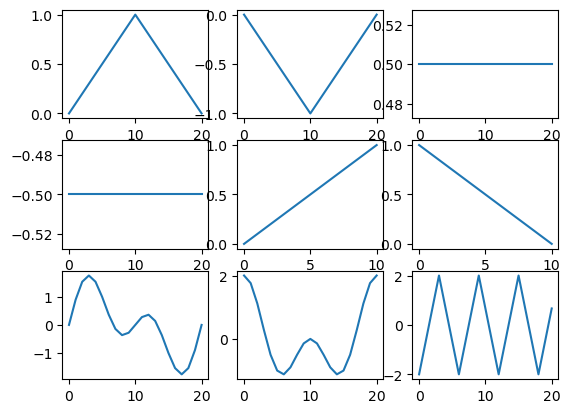

In [4]:
fig, axes = plt.subplots(3, 3)
ss = [s1, s2, s3, s4, s5, s6, s7, s8, s9]
for i in range(3):
    for j in range(3):
        axes[i, j].plot(ss[i * 3 + j], label=f's{i * 3 + j}')

In [5]:
def data_shapelet(shapelets,mean = 0,input_length=150, shapelet_length=21,std_dev = 0.01,num = 500):

    c = np.zeros((num,1,input_length))
    num_shapelet = len(shapelets)
    for i in range(num):
        a = np.zeros(input_length) 

        # instance_startings = multiple_insert_shapelet(input_length, num_shapelet, shapelet_length)
        for j, shapelet in enumerate(shapelets):
            start = np.random.randint(j * 100 + 10,j * 100 + 70)
            # starting = np.random.randint(input_length-shapelet_length)
            a[start:start + shapelet_length] = shapelet
            a = a + np.random.normal(mean, std_dev, a.shape)
            c[i] = a.reshape(1,input_length)
    return c #z_normalization(c)

In [6]:
input_length = 300
shapelet_length = 21
std_dev = 0.05
num = 100

In [7]:
def data_generation(num=100):
    c0_1 = data_shapelet([s2,s1,s1], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    c0_2 = data_shapelet([s1,s2,s2], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    # c0_3 = data_shaplet([s1,s6], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    # c0_4 = data_shaplet([s1], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    
    c1_1 = data_shapelet([s2,s1,s2], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    c1_2 = data_shapelet([s1,s2,s1], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    # c1_3 = data_shaplet([s6], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    # c1_4 = data_shaplet([], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    

    return np.concatenate([c0_1,c0_2,c1_1,c1_2]), np.concatenate([[0]*num*2,[1]*num*2])
train_x, train_y = data_generation(num=100)
test_x, test_y = data_generation(num=100)

enc1 = sklearn.preprocessing.OneHotEncoder(sparse_output=False).fit(train_y.reshape(-1, 1))
train_y = enc1.transform(train_y.reshape(-1, 1))
test_y = enc1.transform(test_y.reshape(-1, 1))

In [13]:
model_name = 'InceptionTime'
task = 'motiv1_new'
model_dataset_path = f'models/{model_name}/{task}/'
device = 'cuda'

In [14]:
# enc1 = sklearn.preprocessing.OneHotEncoder(sparse_output=False).fit(train_y.reshape(-1, 1))
# train_y = enc1.transform(train_y.reshape(-1, 1))
# test_y = enc1.transform(test_y.reshape(-1, 1))
data = {
    'train_x': train_x,
    'test_x': test_x,
    'train_y': train_y,
    'test_y': test_y
}

if not os.path.exists(model_dataset_path):
    os.makedirs(model_dataset_path)

with open(model_dataset_path+'/data.pkl', 'wb') as f:
    pickle.dump(data, f)

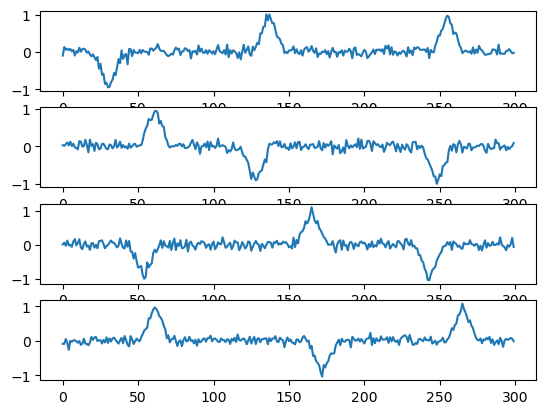

In [15]:
fig, axes = plt.subplots(4, 1)
axes[0].plot(test_x[0].flatten(),label='c0')
axes[1].plot(test_x[100].flatten(),label='c0')
axes[2].plot(test_x[200].flatten(),label='c1')
axes[3].plot(test_x[300].flatten(),label='c1')

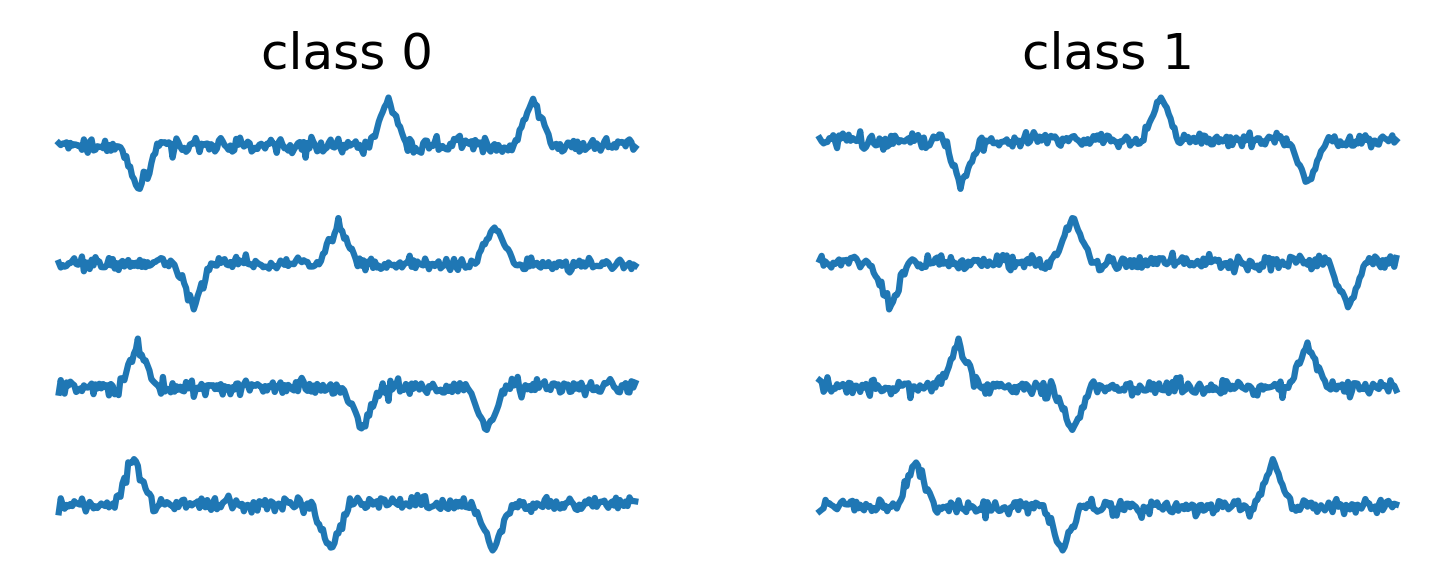

In [16]:
# fig, axes = plt.subplots(4, 1)
# axes[0].plot(train_x[0].flatten(),label='c0')
# axes[1].plot(train_x[100].flatten(),label='c0')
# axes[2].plot(train_x[200].flatten(),label='c1')
# axes[3].plot(train_x[300].flatten(),label='c1')
fig, axes = plt.subplots(4, 2, dpi=300, figsize=(6, 2))
for i in range(2):
    for j in range(2):
        axes[j, i].plot(train_x[i * 200 + j].flatten())
    for j in range(2):
        axes[j + 2, i].plot(train_x[i * 200 + 100 + j].flatten())
    for j in range(4):
        axes[j, i].axis('off')
        
    axes[0, 0].set_title('class 0')
    axes[0, 1].set_title('class 1')

In [17]:
model = InceptionTime(c_in=1, c_out=2)
train_loader, test_loader = generate_loader(train_x, test_x, train_y, test_y, batch_size_train=128, batch_size_test=32)
fit(model, train_loader, device=device, num_epochs=500)

torch.save(model.state_dict(), f'{model_dataset_path}/weight.pt')
test_preds, ground_truth = get_all_preds(model, test_loader, device=device)
ground_truth = np.argmax(ground_truth, axis=1)
np.save(f'{model_dataset_path}/test_preds.npy', np.array(test_preds))
acc = accuracy_score(ground_truth, test_preds)
print(f'test_preds acc:{acc:.3f}')
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'{model_dataset_path}/classification_report.csv', index=False)


train_preds, ground_truth = get_all_preds(model, train_loader, device=device)
ground_truth = np.argmax(ground_truth, axis=1)
# np.save(f'{model_dataset_path}/test_preds.npy', np.array(test_preds))
acc = accuracy_score(ground_truth, train_preds)
print(f'train_preds acc:{acc:.3f}')

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:35<00:00, 13.99it/s]

test_preds acc:1.000
train_preds acc:1.000


In [18]:
from utils.insert_shapelet import get_attr
from utils.visualization import plot_multiple_images_with_attribution

In [19]:
attr_class = None
for xai_name in ['DeepLift']:
    attr_save_dir = f'attributions/{model_name}/{task}/{xai_name}/'


    attr, _ = get_attr(model, test_x, None, None,
                      save_dir=os.path.join(attr_save_dir, 'test_exp.pkl'),
                      xai_name=xai_name, target_class=attr_class)


def plot(ax, y, v, norm, alpha=1.0, lw=1.0):
        x = np.arange(len(y))
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap='coolwarm', norm=norm, lw=3)

        lc.set_array(v)
        lc.set_alpha(alpha)
        lc.set_linewidths(lw)
        ax.add_collection(lc)
        ax.autoscale()


indices = [0, 1, 100, 101, 200, 201, 300, 301]
x_vis = test_x[indices].squeeze()
attr_vis = attr[indices]
extremum = np.mean(attr_vis) + 3 * np.std(attr)
norm = mcolors.Normalize(vmin=-extremum, vmax=extremum)

fig, axes = plt.subplots(4, 2, dpi=300, figsize=(6, 2))
for i in range(8):
    plot(axes[i // 2, i % 2], x_vis[i], attr_vis[i], norm)
    axes[i // 2, i % 2].axis('off')

axes[0, 0].set_title('class 0')
axes[0, 1].set_title('class 1')

im = cm.ScalarMappable(norm=norm, cmap='coolwarm')
fig.colorbar(im, ax=axes.ravel().tolist())

/home/zwkan/miniconda3/envs/XAI2/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/zwkan/miniconda3/envs/XAI2/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


RuntimeError: A Module ReLU() was detected that does not contain some of the input/output attributes that are required for DeepLift computations. This can occur, for example, if your module is being used more than once in the network.Please, ensure that module is being used only once in the network.

# shapelet

In [78]:
# def data_generation_clean(num=10):
#     std_dev = 0
#     c0_1 = data_shapelet([s1,s3], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
#     c0_2 = data_shapelet([s2,s4], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
#     # c0_3 = data_shaplet([s1,s6], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
#     # c0_4 = data_shaplet([s1], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    
#     c1_1 = data_shapelet([s1,s4], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
#     c1_2 = data_shapelet([s2,s1], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
#     # c1_3 = data_shaplet([s6], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
#     # c1_4 = data_shaplet([], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    

#     return np.concatenate([c0_1,c0_2,c1_1,c1_2]), np.concatenate([[0]*num*2,[1]*num*2])
# # train_x, train_y = data_generation()
# test_x_clean, test_y_clean = data_generation_clean(num=10)

# enc1 = sklearn.preprocessing.OneHotEncoder(sparse_output=False).fit(train_y.reshape(-1, 1))
# train_y = enc1.transform(train_y.reshape(-1, 1))
# test_y = enc1.transform(test_y.reshape(-1, 1))

In [15]:
from pyts.transformation import ShapeletTransform

window_sizes = np.arange(10,22)
# window_sizes
# st = ShapeletTransform(window_sizes=[20,21,22],random_state=42, sort=True, n_jobs=8)
st = ShapeletTransform(window_sizes=[21, 48, 75], random_state=42, sort=True, n_jobs=12)
st_indices = []
for i in range(4):
    for j in range(10):
        st_indices.append(i * 100 + j)
print(st_indices)
X_new = st.fit_transform(test_x.reshape(test_x.shape[0],test_x.shape[-1]), np.argmax(test_y,axis=1))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309]


In [ ]:
from pyts.classification import LearningShapelets
clf = LearningShapelets(random_state=42, tol=0.01)
clf.fit(train_x.reshape(train_x.shape[0],train_x.shape[-1]), np.argmax(train_y,axis=1))

In [ ]:
y_pred = clf.predict(test_x.reshape(test_x.shape[0],test_x.shape[-1]))
_y = np.argmax(test_y, axis=1)
np.count_nonzero(y_pred == _y) / len(y_pred)

In [ ]:
for i, shapelet in enumerate(clf.shapelets_[0,:4]):
    # idx, start, end = index
    # print(index,test_y[idx])
    # plt.plot(test_x[idx].flatten(), color='C{}'.format(i),
    #          label='Sample {}'.format(idx))
    # plt.plot(np.arange(start, end), test_x[idx,:, start:end].flatten(),
    #          lw=5, color='C{}'.format(i))
    plt.figure(figsize=(4.8, 1.2))
    plt.plot(shapelet.flatten(),
         lw=5, color='C{}'.format(i))
    plt.show()


In [23]:
print(np.mean(X_new[:100,0]))
print(np.mean(X_new[100:200,0]))
print(np.mean(X_new[200:300,0]))
print(np.mean(X_new[300:400,0]))

st.scores_

0.204365879866735
0.29507518944511796
0.22556416698523932
0.21263361826632476


array([0.2049297 , 0.17490738, 0.17417822, 0.17384141, 0.1736192 ,
       0.1728635 , 0.17221548, 0.17043945, 0.16861251, 0.16814552,
       0.16775068, 0.16625381, 0.16604896, 0.1651123 , 0.16238915,
       0.16122915, 0.16121251, 0.15871109, 0.15848853, 0.15794267,
       0.15733011, 0.15718254, 0.15714207, 0.15694488, 0.15653476,
       0.15622425, 0.15613786, 0.15608846, 0.1553079 , 0.15483211,
       0.15430017, 0.15422907, 0.15422638, 0.15422076, 0.15417288,
       0.15392904, 0.15380313, 0.15365068, 0.15229417, 0.1519571 ,
       0.15170325, 0.15147331, 0.15120267, 0.15104657, 0.15088743,
       0.15079913, 0.15072385, 0.15056931, 0.15039152, 0.15034422,
       0.15029494, 0.15021053, 0.15006984, 0.15001567, 0.14958657,
       0.14878249, 0.14858233, 0.14844584, 0.14813031, 0.14802315,
       0.14799198, 0.14784208, 0.1478013 , 0.14776448, 0.14744097,
       0.14734376, 0.14717143, 0.14698085, 0.14688428, 0.14650267,
       0.14596502, 0.14586799, 0.14542082, 0.14536824, 0.14531

150


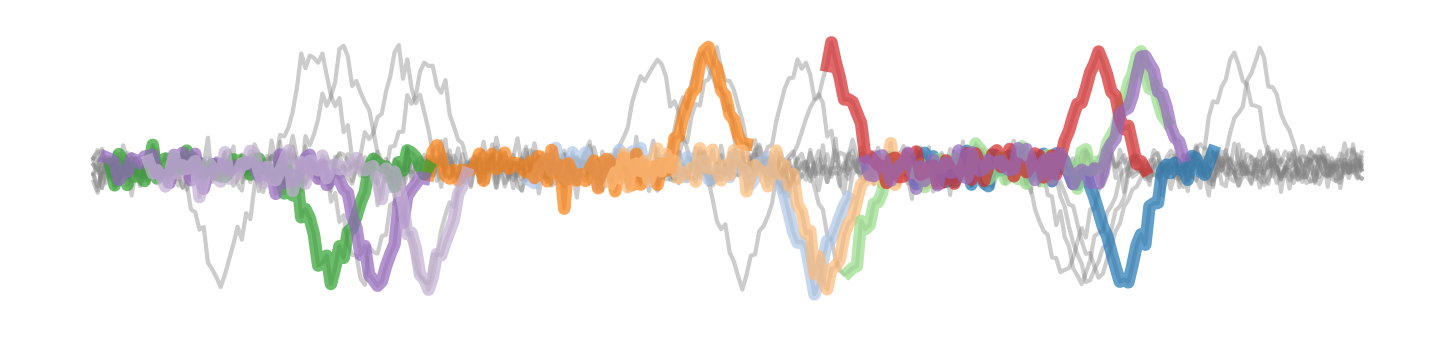

In [135]:
results = []

plt.figure(figsize=(6, 1.2), dpi=300)

print(len(st.indices_))

ind = np.random.choice(np.arange(len(st.indices_)), 10, replace=False)
# ind = np.arange(len(st.indices_) - 8, len(st.indices_))

for i, index in enumerate(st.indices_[ind]):
    idx, start, end = index
    item = {'sample': test_x[idx], 'start': start, 'end': end, 'idx': idx}
    results.append(item)
    
    # print(index,test_y[idx])
    plt.plot(test_x[idx].flatten(), lw=1, color='gray', alpha=0.4)

for i, index in enumerate(st.indices_[ind]):
    idx, start, end = index

    item = {'sample': test_x[idx], 'start': start, 'end': end, 'idx': idx}
    results.append(item)
    # print(index,test_y[idx])
    plt.plot(np.arange(start, end + 1), test_x[idx].flatten()[start:end + 1], lw=3, alpha=0.7, color=plt.get_cmap('tab20')(i if i != 7 else 8))

plt.axis('off')

with open('./output/motiv1/ST.pkl', 'wb') as f:
    pickle.dump(results,f)

In [109]:
with open(f'models/{model_name}/{task}/data.pkl', 'rb') as f:
    data = pickle.load(f)
train_x, test_x, train_y, test_y = data['train_x'], data['test_x'], data['train_y'], data['test_y']

In [15]:
x= test_x.transpose(0, 2, 1)

In [20]:
dataset = 'GunPoint'
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(dataset)
X_train = X_train.transpose(0, 2, 1)
X_test = X_test.transpose(0, 2, 1)
clf = ShapeletTransformClassifier(
    estimator=RotationForestClassifier(n_estimators=3),
    n_shapelet_samples=100,
    max_shapelets=10,
    batch_size=20,
    random_state=42,
)
clf.fit(X_train, y_train).

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Correct classification rate:{acc:.2f}")

Correct classification rate:0.96


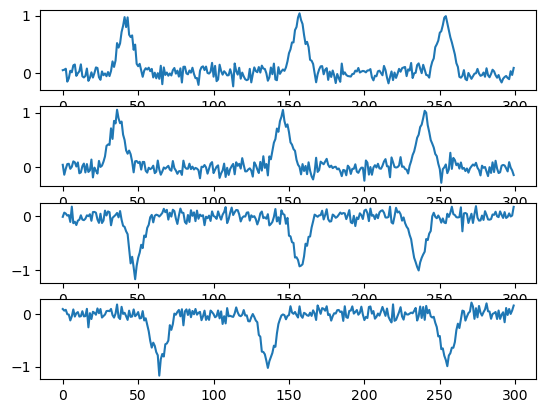

In [188]:
# from sktime.classification.shapelet_based import ShapeletTransformClassifier
# from sktime.classification.sklearn import RotationForest
# # from sktime.datasets import load_unit_test
# # X_train, y_train = load_unit_test(split="train", return_X_y=True)
# # X_test, y_test = load_unit_test(split="test", return_X_y=True) 
# clf = ShapeletTransformClassifier(
#     estimator=RotationForest(n_estimators=3),
#     n_shapelet_samples=100,
#     max_shapelets=10,
#     batch_size=20,
# ) 
# clf.fit(x, np.argmax(train_y,axis=1))
# y_pred = clf.predict(x) 

def data_generation(num=100):
    c0_1 = data_shapelet([s1, s1, s1], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    c0_2 = data_shapelet([s1, s1, s1], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    # c0_3 = data_shaplet([s1,s6], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    # c0_4 = data_shaplet([s1], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    
    c1_1 = data_shapelet([s2,s2,s2], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    c1_2 = data_shapelet([s2,s2,s2], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    # c1_3 = data_shaplet([s6], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    # c1_4 = data_shaplet([], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    

    return np.concatenate([c0_1,c0_2,c1_1,c1_2]), np.concatenate([[0]*num*2,[1]*num*2])
train_x, train_y = data_generation(num=100)
test_x, test_y = data_generation(num=100)

enc1 = sklearn.preprocessing.OneHotEncoder(sparse_output=False).fit(train_y.reshape(-1, 1))
train_y = enc1.transform(train_y.reshape(-1, 1))
test_y = enc1.transform(test_y.reshape(-1, 1))

fig, axes = plt.subplots(4, 1)
axes[0].plot(train_x[0].flatten(),label='c0')
axes[1].plot(train_x[100].flatten(),label='c0')
axes[2].plot(train_x[200].flatten(),label='c1')
axes[3].plot(train_x[300].flatten(),label='c1')

In [193]:
from aeon.classification.shapelet_based import ShapeletTransformClassifier
from aeon.classification.sklearn import RotationForestClassifier

x = test_x.transpose(0, 2, 1)

print(x.shape)
clf = ShapeletTransformClassifier(
    # estimator=RotationForestClassifier(n_estimators=3),
    # n_shapelet_samples=100,
    # max_shapelets=10,
    max_shapelet_length=150,
    # batch_size=20,
    random_state=42,
)
clf.fit(x, np.argmax(train_y,axis=1))

y_pred = clf.predict(x)
acc = accuracy_score(np.argmax(train_y,axis=1), y_pred)
print(f"Correct classification rate:{acc:.2f}")


(400, 300, 1)


ValueError: high <= 0

In [73]:
implets = implet_extractor(test_x, test_y, attr, kmin=5)

[167, 102, 252, 116, 74, 320, 69, 72, 265, 79]


(-14.950000000000001, 313.95, -1.2043195793549275, 1.1901888064873034)

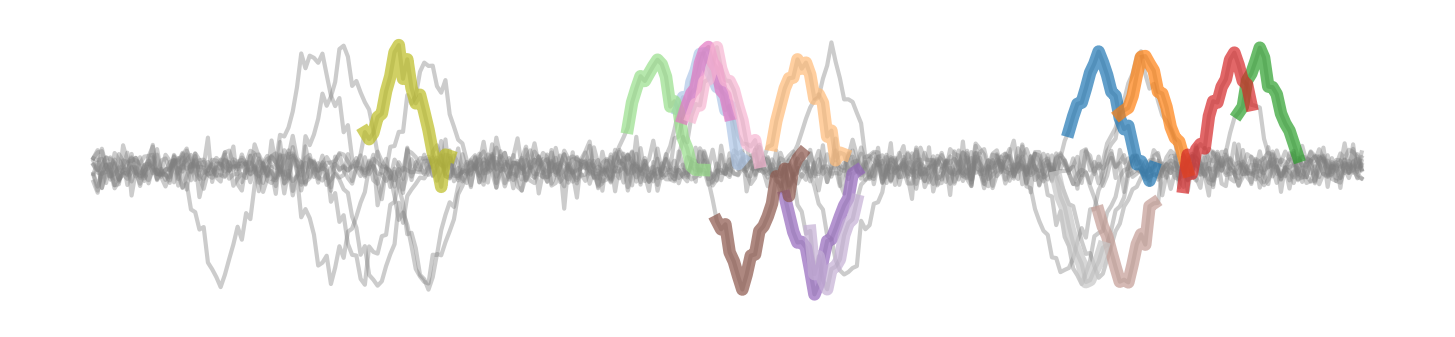

In [143]:
plt.figure(figsize=(6, 1.2), dpi=300)

for i, index in enumerate(st.indices_[ind]):
    idx, start, end = index
    item = {'sample': test_x[idx], 'start': start, 'end': end, 'idx': idx}
    results.append(item)
    
    # print(index,test_y[idx])
    plt.plot(test_x[idx].flatten(), lw=1, color='gray', alpha=0.4)

sample_indices = [idx for idx, _, _ in st.indices_[ind]]
print(sample_indices)
i = 0
for idx, _, _, _, start, end in implets:
    if idx in sample_indices:
        color_idx = i + i // 7
        if color_idx % 7 == 0 and color_idx != 0:
            color_idx += 1
        plt.plot(np.arange(start, end + 1), 
                 test_x[idx].flatten()[start:end + 1], 
                 lw=3, alpha=0.7, 
                 color=plt.get_cmap('tab20')(color_idx))
        i += 1

plt.axis('off')